In [2]:
%pylab inline
import tifffile
import seaborn as sns
sns.set_style("white")

Populating the interactive namespace from numpy and matplotlib


In [3]:
I = array(tifffile.imread("./rubisco_002.tif"), dtype=float64)
for i in range(I.shape[0]):
    I[i, :, :] -= median(I[i, :, :])
I2 = -I[:2000,:2000,0]

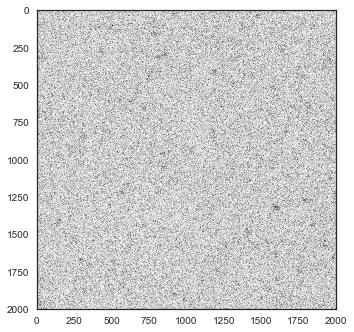

In [4]:
imshow(I2)

In [5]:
fI2 = fftshift(fft2(I2-median(I2)))

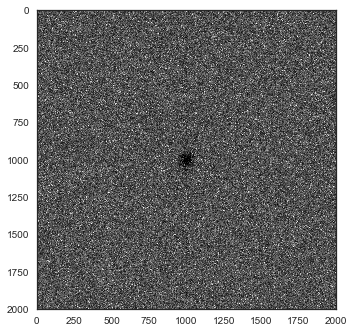

In [6]:
from matplotlib.colors import LogNorm
imshow(abs(fI2), norm=LogNorm(500,100000))

/Users/max.hantke/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


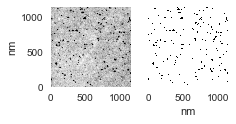

In [44]:
from scipy.ndimage import gaussian_filter
sI2 = gaussian_filter(I2, 5.)
M = sI2 > 5
N = M.shape[0]
l = N/876.*500
extent = [0, l, 0, l]
sf = 0.7
fig, (ax1, ax2) = subplots(ncols=2, figsize=(sf*5, sf*2.7), sharey=True)
ax1.imshow(sI2, vmax=10, extent=extent)
#ax2.imshow(sI2, vmax=10, extent=extent)
ax2.imshow(log10(10*M), cmap="binary", vmin=0, extent=extent)
ax1.set_aspect(1.)
ax2.set_aspect(1.)
ax2.set_xlabel("nm")
ax1.set_ylabel("nm")
ax2.set_xlabel("nm")
for ax in [ax1, ax2]:
    ax.set_frame_on(False)
tight_layout()
savefig("thresholding.png", dpi=300)

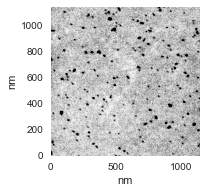

In [34]:
from scipy.ndimage import gaussian_filter
sI2 = gaussian_filter(I2, 5.)
M = sI2 > 5
N = M.shape[0]
l = N/876.*500
extent = [0, l, 0, l]
fig, ax = subplots(nrows=1, figsize=(3., 3.))
ax.imshow(sI2, vmax=10, extent=extent)
ax.set_aspect(1.)
ax.set_xlabel("nm")
ax.set_ylabel("nm")
ax.set_frame_on(False)
tight_layout()
savefig("thresholding_single.png", dpi=300)

In [11]:
from scipy.ndimage import label
L, nL = label(M)

In [12]:
A = zeros(nL)
for i in range(nL):
    A[i] = (L == i+1).sum()
d = sqrt(A/pi)*2
# scale 500 nm = 876 pixel
d_nm = d/876.*500
# Save data for Johan
import h5py
with h5py.File("particles_rubisco_002.h5", "w") as f:
    f["particle_area"] = A
    f["particle_diameter"] = d
    f["particle_diameter_nm"] = d_nm

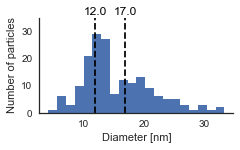

In [37]:
sf = 0.7
fig = figure(figsize=(5*sf,3*sf))
ax = fig.add_subplot(111)
d1 = 12.
d2 = d1*sqrt(2)
ax.axvline(d1,c="black", ls='--')
ax.axvline(d2,c="black", ls='--')
ax.hist(d_nm,20,lw=0)
ax.set_ylabel("Number of particles")
ax.set_xlabel("Diameter [nm]")
ax.set_ylim(0, 35)
ax.text(d1, 36, "%.1f" % round(d1,1), ha="center", color="black")
ax.text(d2, 36, "%.1f" % round(d2,1), ha="center", color="black")
sns.despine()
tight_layout()
savefig("hist.png", dpi=250)

In [134]:
import cv2

ImportError: No module named cv2